Download database.

In [ ]:
!wget -r -N -c -np -q https://physionet.org/files/slpdb/1.0.0/

Download libraries.

In [ ]:
!pip install -q wfdb
!python -m pip uninstall -q matplotlib
!pip install -q matplotlib==3.1.3

     |████████████████████████████████| 137 kB 7.3 MB/s 
     |████████████████████████████████| 11.2 MB 54.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Proceed (y/n)? y
     |████████████████████████████████| 13.1 MB 7.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires matplotlib>=3.3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Import libraries.

In [ ]:
# For reading database
import wfdb
import os
import copy
import numpy as np
import scipy as sp
from tensorflow.keras import models, layers
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import librosa
import librosa.display

np.random.seed(1)

## **1. Import Database**
Accessing data and basic data processing.


In [ ]:
class PatientData (object):
    ECG_signal = None
    EEG_signal = None
    sleep_stages = None

    record_length = None
    sampling_frequency = None

    def __init__ (self, patient_name):
        self.patient_name = patient_name

In [ ]:
DATABASE_PATH = 'physionet.org/files/slpdb/1.0.0'

with open(os.path.join(DATABASE_PATH, 'RECORDS'), 'r') as file:
    PATIENT_NAMES = file.read().split('\n')[:-1]
  
PATIENTS = {
    patient_name: PatientData(patient_name)
    for patient_name in PATIENT_NAMES
}

In [ ]:
# 0 Awake
# 1 NREM stage 1
# 2 NREM stage 2
# 3 NREM stage 3 and 4
# 4 REM
def annotation_sleep_stage (annotation):
    if annotation.startswith('W'):
        return 0
    elif annotation.startswith('1'):
        return 1
    elif annotation.startswith('2'):
        return 2
    elif annotation.startswith('3') or annotation.startswith('4'):
        return 3
    elif annotation.startswith('R'):
        return 4
    # Ideally, all annotations are classified into one of the above 5
    else:
        return -1

# Since annotations only have labels and the time at which they occur,
# interpolate all the data so there's always a label at each time step
def step_interpolation (data, locations, total_length):
    step_interpolated_data = np.zeros(total_length)

    for i in range(len(locations) - 1):
        start_range = locations[i]
        end_range = locations[i + 1]

        # Convert string annotation into sleep stage
        step_interpolated_data[(start_range - 1) : end_range] = annotation_sleep_stage(data[i])

    return step_interpolated_data

In [ ]:
for patient_name in PATIENT_NAMES:
    patient = PATIENTS[patient_name]

    # Retrieve raw signals and annotations
    record_path = os.path.join(DATABASE_PATH, patient_name)
    record = wfdb.io.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, extension='st')

    # Sampling frequency
    # This might differ for each record
    patient.sampling_frequency = record.fs

    # 0 ECG
    # 1 BP
    # 2 EEG
    # 3 Resp (not available for all)
    patient.ECG_signal = record.p_signal[:, 0]
    patient.EEG_signal = record.p_signal[:, 2]
    patient.record_length = record.sig_len

    patient.sleep_stages = step_interpolation(annotation.aux_note, annotation.sample, patient.record_length)

In [ ]:
# Example patient
patient_slp01a = PATIENTS['slp01a']
print(patient_slp01a.ECG_signal)
print(patient_slp01a.EEG_signal)
print(patient_slp01a.sleep_stages)


[0.085 0.08  0.125 ... 0.23  0.235 0.225]
[-0.03919129 -0.03888025 -0.03856921 ...  0.14727838  0.14681182
  0.14261275]
[3. 3. 3. ... 0. 0. 0.]


In [ ]:
# Splitting the dataset into train, validation, test set
# Will be split in terms of patients, not sleep data
num_patients = len(PATIENTS)

# Shuffle patients
randomized_patients = copy.deepcopy(list(PATIENTS.keys()))
np.random.shuffle(randomized_patients)

# 80 / 10 / 10 split of 18 patients will be roughly 14 / 2 / 2
# Don't need test_end, since it'll be until the end of data
train_end = 14
valid_end = train_end + 2

# Split data using keys
train_patients = randomized_patients[ : train_end]
valid_patients = randomized_patients[train_end : valid_end]
test_patients = randomized_patients[valid_end : ]

## **2. Building the Neural Network**

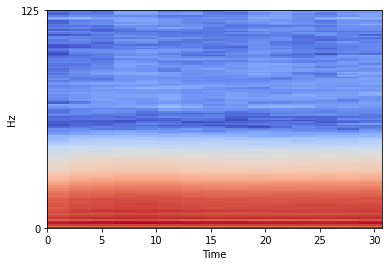

In [ ]:
# Sample data to test out CNN
sample_patient = PATIENTS[train_patients[0]]

# One batch is 30 seconds of EEG and ECG data
num_samples_in_one_second = float(1 / sample_patient.sampling_frequency)
num_samples_in_one_datum = int(30 / num_samples_in_one_second)

# Calculate MFCC's for ECG only
sample_ECG_MFCC = librosa.feature.melspectrogram(
    y=librosa.to_mono(sample_patient.ECG_signal[ : num_samples_in_one_datum]), 
    sr=sample_patient.sampling_frequency)

sample_ECG_MFCC_db = librosa.power_to_db(sample_ECG_MFCC)
librosa.display.specshow(
    sample_ECG_MFCC_db, 
    x_axis='time', 
    y_axis='mel', 
    sr=sample_patient.sampling_frequency)

In [ ]:
train_data = None
train_labels = None

for patient_name in train_patients:
    # Get training data for one patient
    print("Batching {} patient data...".format(patient_name))
    patient = PATIENTS[patient_name]

    # Calculate total number of samples for this patient
    num_samples_in_one_second = float(1 / patient.sampling_frequency)
    num_samples_in_one_datum = int(30 / num_samples_in_one_second)
    total_num_samples = int(patient.EEG_signal.shape[0] / num_samples_in_one_datum)

    for i in range(total_num_samples):
        # Determine start and end of current batch
        start = (i * num_samples_in_one_datum)
        end = ((i + 1) * num_samples_in_one_datum)
        
        EEG_MFCC = librosa.feature.melspectrogram(
            y=patient.EEG_signal[start : end], 
            sr=patient.sampling_frequency)
        ECG_MFCC = librosa.feature.melspectrogram(
            y=patient.ECG_signal[start : end], 
            sr=patient.sampling_frequency)
        
        sample = np.expand_dims(
            np.stack([ EEG_MFCC, ECG_MFCC ], axis=2), 
            axis=0)
        
        # Only grab the label at the end of the current batch
        # This is such that we're using all of the data in the current batch
        # in order to predict the sleep stage by the end of the batch
        sample_labels = np.array([ patient.sleep_stages[end - 1] ])

        if train_data is None:
            train_data = sample
            train_labels = sample_labels
        else:
            train_data = np.append(train_data, sample, axis=0)
            train_labels = np.append(train_labels, sample_labels, axis=0)

    break

print(train_data.shape)
print(train_labels.shape)

Batching slp14 patient data...
(720, 128, 15, 2)
(720,)


In [ ]:
filter_size = 3
pool_size = 2

width, height = sample_EEG_MFCC.shape

model = models.Sequential([
    layers.Conv2D(16, (filter_size, filter_size), activation='relu', input_shape=(width, height, 2)),
    layers.MaxPooling2D((pool_size, pool_size)),

    layers.Flatten(), 
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 126, 13, 16)       304       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 63, 6, 16)        0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 6048)              0         
                                                                 
 dense_33 (Dense)            (None, 32)                193568    
                                                                 
 dense_34 (Dense)            (None, 5)                 165       
                                                                 
Total params: 194,037
Trainable params: 194,037
Non-trainable params: 0
_______________________________________________

In [ ]:
# Train the neural network

history = model.fit(
  train_data,
  utils.to_categorical(train_labels),
  epochs=10
)

Epoch 1/10
23/23 [==============================] - 1s 22ms/step - loss: 74.5527 - accuracy: 0.3708
Epoch 2/10
23/23 [==============================] - 1s 23ms/step - loss: 16.1546 - accuracy: 0.4625
Epoch 3/10
23/23 [==============================] - 1s 23ms/step - loss: 6.9155 - accuracy: 0.5097
Epoch 4/10
23/23 [==============================] - 1s 24ms/step - loss: 6.5024 - accuracy: 0.5292
Epoch 5/10
23/23 [==============================] - 0s 22ms/step - loss: 6.3370 - accuracy: 0.5639
Epoch 6/10
23/23 [==============================] - 1s 22ms/step - loss: 3.7056 - accuracy: 0.6208
Epoch 7/10
23/23 [==============================] - 1s 22ms/step - loss: 2.7439 - accuracy: 0.6583
Epoch 8/10
23/23 [==============================] - 1s 22ms/step - loss: 2.8829 - accuracy: 0.6653
Epoch 9/10
23/23 [==============================] - 1s 22ms/step - loss: 2.9876 - accuracy: 0.6361
Epoch 10/10
23/23 [==============================] - 1s 22ms/step - loss: 3.2233 - accuracy: 0.6139


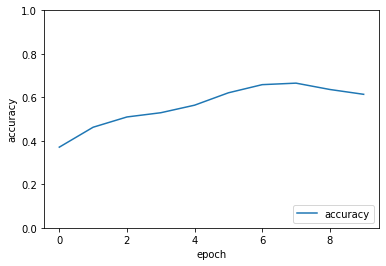

In [ ]:
# Graph training accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
# Get accuracy of the network
model.evaluate(validation_data)

In [ ]:
# implementing the class of conv net -- incompleted
class CNN_sleep_stages(tf.Module):
  def __init__(self, number_of_channels = , number_of_classes =):
    self.conv1 = models.Sequential(layers.Conv2D(, (, ), activation='relu', input_shape=(, , )))
    self.conv2 = models.Sequential(layers.Conv2D(, (, ), activation='relu'))
    self.pool =  models.Sequential(layers.MaxPool2D( 2 , 2 ))
    self.flat = models.Sequential(layers.Flatten())
    self.dense = models.Sequential(layers.Dense(, activation = 'Sigmoid'))
  
  def __call__(self, x):
    x = self.pool(self.conv1(x))
    return x

# Could improve the accuracy by:
# 1. Increasing the depth (adding more convolutional layer)
# 2. Adding dropout layer
# 3. Add fully-connected layers
# 4. Strides? Padding?